<font size="5">Introduction</font>

Wine type is very important to many people, connoisseurs and distributors alike. The type of a wine can be a factor in determining many different things, including its value and intended purpose (when it is used). There are a multitude of factors in a wine that can contribute to its overall categorization, however we will be exploring if a wine is a red or a white based on specific qualities.

Thus, this project will analyze contributors and develop a system adept to determining the type of a batch of wine (red or white). We aim to predict the type of wine using a classification model based on the three factors we determined to be the most important: Volatile Acidity, Chlorides, and Total Sulfur Dioxide.

The dataset, with 6497 rows and 13 columns, is obtained from the UCI Machine Learning Repository. It can be found at https://www.kaggle.com/datasets/rajyellow46/wine-quality, and displays a number of measurable factors of wines including but not limited to those mentioned above - as well as the type of wine (red or white). Not all wine types are presented equally. It was collected in 2009 and combines two data sets. A total of 11 measured factors of wine are present, some represented in a scale of integers and others on a continuous scale. We have researched and selected the three above factors to predict wine type as not all factors are of equal importance.

In [26]:
install.packages("kknn")
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(ggplot2)
library(patchwork)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [27]:
wine_type <- read_csv("https://raw.githubusercontent.com/mickdobrov/DSCI-Project/main/winequalityraw.csv")
names(wine_type) <- make.names(colnames(wine_type))

w_type <-wine_type|>
                select(volatile.acidity, chlorides, total.sulfur.dioxide, type) |>
                na.omit(volatile.acidity, chlorides, total.sulfur.dioxide, type)
w_type$volatile.acidity <- as.numeric(w_type$volatile.acidity)
w_type$chlorides<-as.numeric(w_type$chlorides)
w_type$total.sulfur.dioxide<-as.numeric(w_type$total.sulfur.dioxide)
w_type$type<-as.factor(w_type$type)

Rows: 6497 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): type
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


<font size="4">Testing and Training Sets:</font>
Dividing the data from the wine dataset allows for creation of a more accurate model, we split this set into a training set of 75% of the data and a testing set of 25% of the data.

In [28]:
set.seed(135)
wine_split <- initial_split(w_type, prop = 0.75, strata = type)
wine_train <- training (wine_split)
wine_test <- testing(wine_split)

In [29]:
#summarize with training data

We then took the training data set, known as wine_train, and summarized it by finding the mean values for each wine type for the predictors we chose to focus on: volatile acidity, chlorides, and total sulfur dioxides. These means were tabulated with their corresponding wine type to try to understand the relationship of the data.

In [30]:
wine_table <- wine_train|>
    group_by(type)|>           
    summarize(mean.vol = mean(volatile.acidity), mean.chlor = mean(chlorides), 
              mean.sulf = mean(total.sulfur.dioxide))

wine_table

type,mean.vol,mean.chlor,mean.sulf
<fct>,<dbl>,<dbl>,<dbl>
red,0.5229007,0.08796494,46.21619
white,0.2773759,0.04582951,137.92499


The means were next graphed in bar charts to visualize the data spread and how predictive the factors could be and contribute to our analysis.


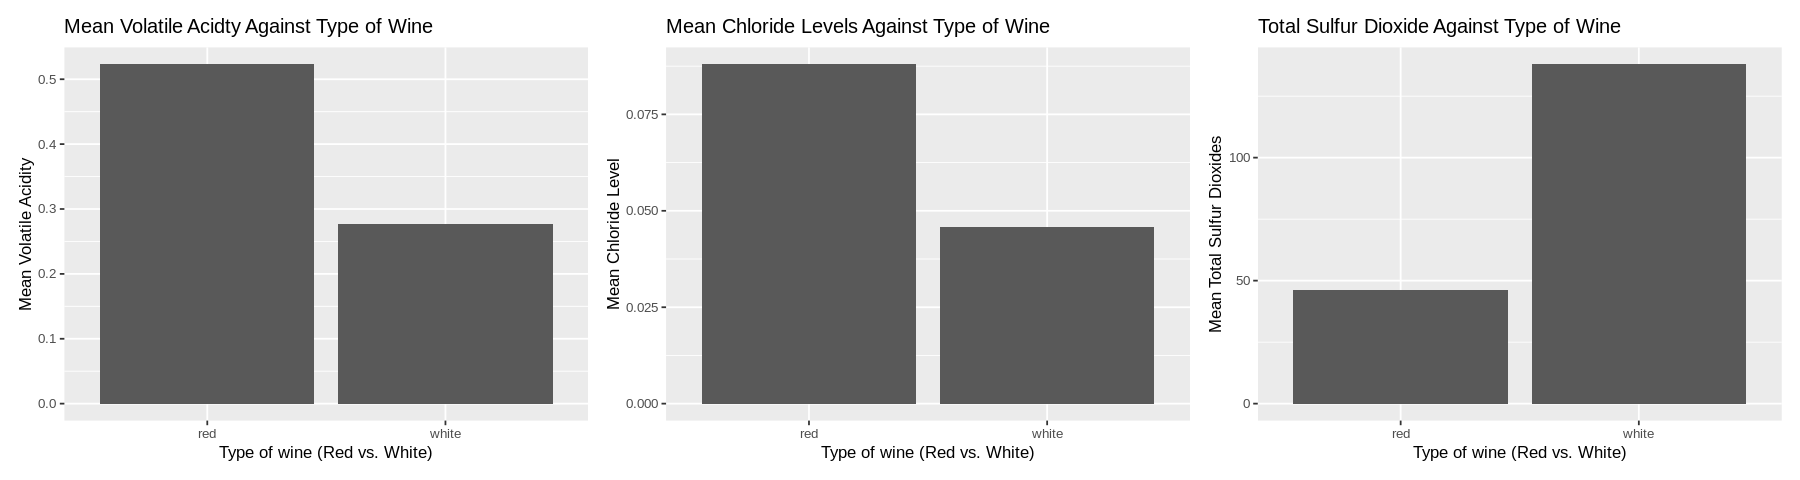

In [31]:

options(repr.plot.height = 4, repr.plot.width = 15)
plot_wine_vol <- wine_table |>
                    ggplot(aes(x= type, y=mean.vol))+
                           geom_bar(stat = "identity") +
                           labs(x = "Type of wine (Red vs. White)", y =  "Mean Volatile Acidity", 
                                title = "Mean Volatile Acidty Against Type of Wine")+
                                theme(text = element_text(size = 10))
                        

plot_wine_chlor <- wine_table |>
                    ggplot(aes(x= type, y=mean.chlor))+
                           geom_bar(stat = "identity") +
                           labs(x = "Type of wine (Red vs. White)", y = "Mean Chloride Level", 
                                title = "Mean Chloride Levels Against Type of Wine")+
                                theme(text = element_text(size = 10))
plot_wine_sulf <- wine_table |>
                    ggplot(aes(x= type, y=mean.sulf))+
                           geom_bar(stat = "identity") +
                           labs(x = "Type of wine (Red vs. White)", y = "Mean Total Sulfur Dioxides", 
                                title = "Total Sulfur Dioxide Against Type of Wine")+
                                theme(text = element_text(size = 10))
                            
plot_wine_vol+plot_wine_chlor+plot_wine_sulf

In [32]:
#vfold

<font size="4">Vfold:</font> the v-fold validation is good for assessing the ability of the model to predict on new data, it does this by creating multiple sets of training and validation data that are run through the model. We did this for our data to help ensure our model was performing accurately and not displaying any results based on the “luck” of the data set it was presented.


In [33]:
wine_vfold <- vfold_cv(wine_train, v = 5, strata = type)

In [34]:
#recipe

<font size="4">Recipe:</font> We import the package and establish the recipe in order to prepare the data to be analyzed. In order to create the recipe we must use the training dataset that we prepared, or else we will encounter issues later on during our analysis.

In [35]:
wine_recipe <- recipe(type ~ volatile.acidity + chlorides + total.sulfur.dioxide , data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

In [36]:
#k-nearest neighbor

<font size="4">K-nearest neighbor:</font> 
K-nearest neighbors is the scale of the predictors. We only use the training data which is wine_train to determine K value. This will ensure that our testing data will not affect the model we build so we can properly examine how the model works on it as a test after it is built.


In [37]:
set.seed(2020)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

In [38]:
wine_fit <- workflow() |>
       add_recipe(wine_recipe) |>
       add_model(knn_spec) |>
       tune_grid(resamples = wine_vfold, grid = 10) |>
       collect_metrics()

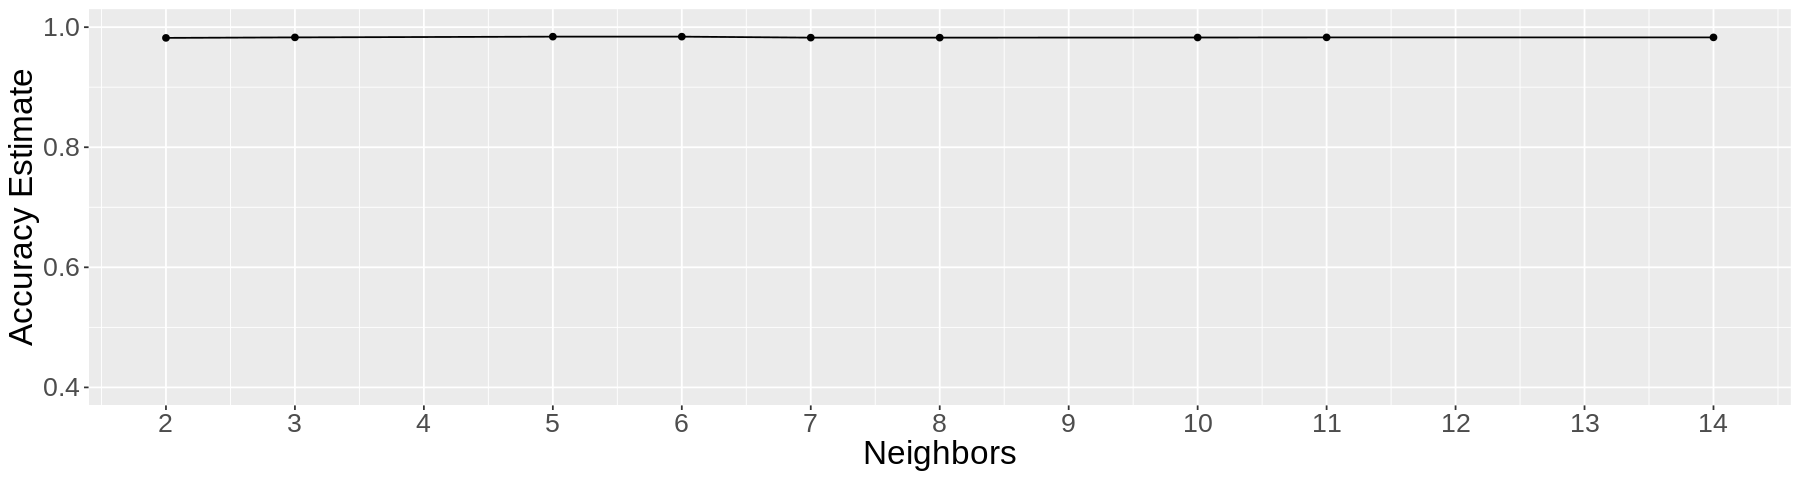

In [39]:
accuracies <- wine_fit |>
              filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                     geom_point() +
                     geom_line() +
                     labs(x = "Neighbors", y = "Accuracy Estimate") +
                     theme(text = element_text(size = 20)) +
                     scale_x_continuous(breaks = seq(0, 14, by = 1)) +
                     scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k

In [40]:
#choose k value

<font size="4">Building the Model:</font> We then build our model based on the training data. Once its completed, we run the testing data through the model, which gives us our metrics (explained in the predictions section)

In [41]:
set.seed(9999) 

wine_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
       set_engine("kknn") |>
       set_mode("classification")

wine_fit <- workflow() |>
             add_recipe(wine_recipe) |>
             add_model(wine_spec) |>
            fit(data = wine_train)
wine_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02097039
Best kernel: rectangular
Best k: 2

<font size="4">Predictions:</font>  We then found the metrics of our model, and examined the results and accuracy of our model based on our models expected outcomes, and the true outcomes. Overall, our model predicted data with extreme accuracy, which will be later explained in the limitations section.

In [42]:
set.seed(9999) 

wine_predictions <- predict(wine_fit, wine_test) |>
                        bind_cols(wine_test)

wine_metrics <- wine_predictions |> metrics(truth = type, estimate = .pred_class)
wine_conf_mat <- wine_predictions |>
                        conf_mat(truth = type, estimate = .pred_class) 
wine_metrics
wine_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9790511
kap,binary,0.9442562


          Truth
Prediction  red white
     red    390    24
     white   10  1199

In [43]:
#visualization

<font size = "4"> Visualizations: </font> The results of our predictive classification model are displayed in a collection of scatterplots of every combination of our predictive factors overlayed with a line graph of the predicted wine type (red vs. white) from our model. From these graphs it is easy to see that the predicted wine types rarely overlap with an incorrect classification from the actual data.


In [44]:
pred_final <- wine_predictions|>
            mutate(predicted.type = .pred_class)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



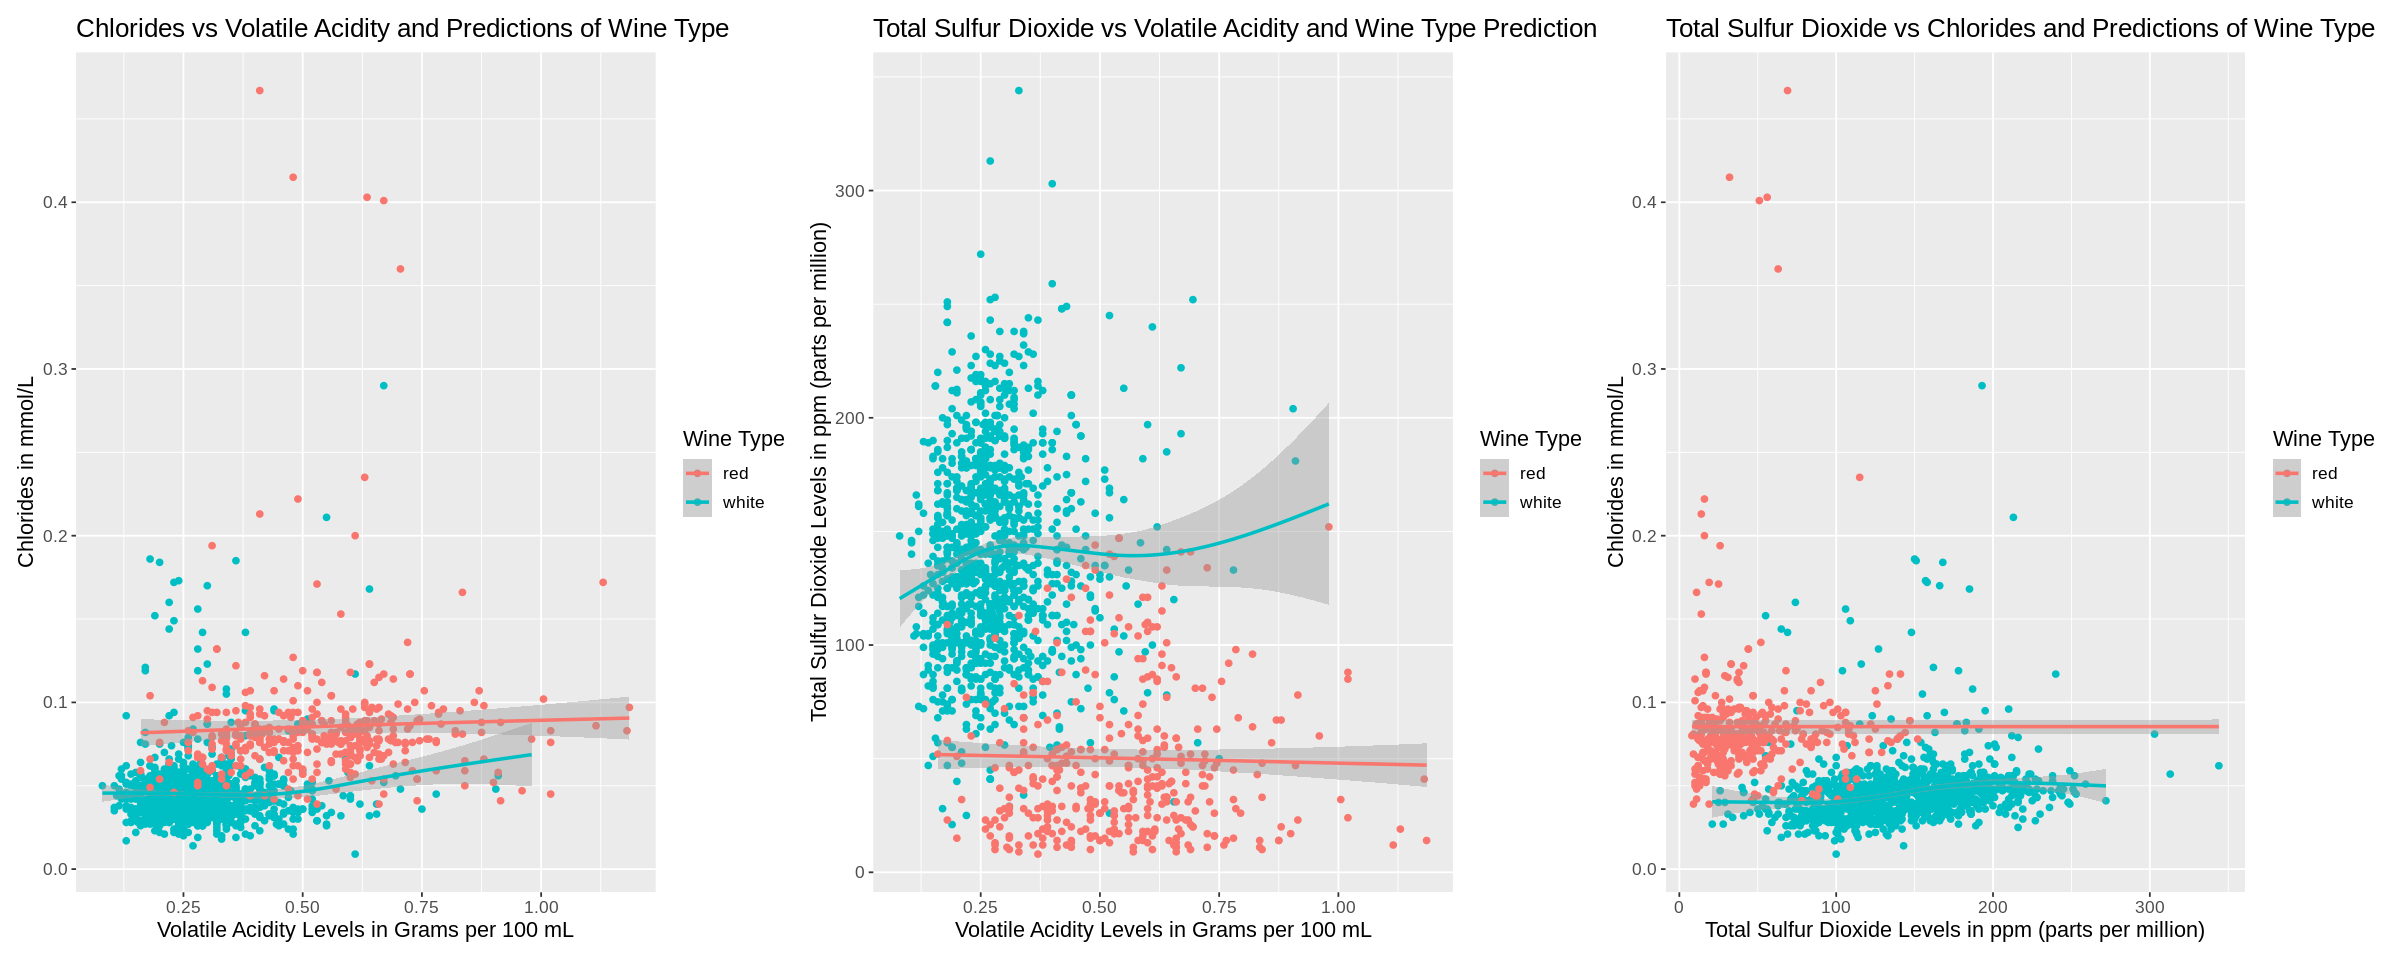

In [45]:
options(repr.plot.height = 8, repr.plot.width = 20)
wine_plot_avc <- wine_test|>
                ggplot(aes(x=volatile.acidity, y = chlorides, color = type))+
                geom_point()+
                geom_smooth(data = pred_final, aes(x = volatile.acidity, y = chlorides, color = predicted.type))+
                labs(x = "Volatile Acidity Levels in Grams per 100 mL", y = "Chlorides in mmol/L", 
                     title = "Chlorides vs Volatile Acidity and Predictions of Wine Type",
                    color = "Wine Type")+
                theme(text = element_text(size = 13))
wine_plot_avt <- wine_test|>
                ggplot(aes(x=volatile.acidity, y = total.sulfur.dioxide, color = type))+
                geom_point()+
                geom_smooth(data = pred_final, aes(x = volatile.acidity, y = total.sulfur.dioxide, color = predicted.type))+
                labs(x = "Volatile Acidity Levels in Grams per 100 mL", y = "Total Sulfur Dioxide Levels in ppm (parts per million)", 
                     title = "Total Sulfur Dioxide vs Volatile Acidity and Wine Type Prediction",
                    color = "Wine Type")+
                theme(text = element_text(size = 13))
wine_plot_tvc <- wine_test|>
                ggplot(aes(x=total.sulfur.dioxide, y = chlorides, color = type))+
                geom_point()+
                geom_smooth(data = pred_final, aes(x = total.sulfur.dioxide, y = chlorides, color = predicted.type))+
                labs(x = "Total Sulfur Dioxide Levels in ppm (parts per million)", y = "Chlorides in mmol/L", 
                     title = "Total Sulfur Dioxide vs Chlorides and Predictions of Wine Type",
                    color = "Wine Type")+
                theme(text = element_text(size = 13))
wine_plot_avc + wine_plot_avt + wine_plot_tvc

<font size = "4"> Limitations of Our Model </font>


Our model had an accuracy level of 97.9 percent, which is unusually high. It is important to note why this is the case in order to understand the limitation of the model that we created. This could be due to a number of different reasons. Firstly, our dataset is limited, in the sense that there are few data points for red wine compared to the number of data for white wine. Secondly, all of the wines in our dataset are from the same vineyard, which could mean that there are differences in the chemical compounds of the grapes and soil (leading to a difference in the composition of the wine, which ultimately could change the factors we use to predict wine type). Thirdly, red wine and white wine might just have some extreme differences when it comes to Volatile Acidity, Chlorides, and Total Sulfur Dioxide – it is possible that the model may be this accurate because there truly is a noticeable difference in the levels of these variables, which makes it easy to predict wine type. This would render the model almost useless in many situations however, with more data, it is possible that a model such as this could help classify wines that are blends of white grape and red grape varieties, as more red than white, or more white than red. 

<font size = "4"> Summary of Findings </font>

Through our model, it is clear that these factors (Volatile Acidity, Chlorides, and Total Sulfur Dioxide) have significant differences in scale if a wine is red vs white. We found that Chlorides and Volatile Acidity are significantly higher in red wines than in white wines. We also found that Total Sulfur Dioxide is higher for white wines than for red wines. Because of this difference, our model was able to predict red wine vs white wine with 97.9% accuracy.
This is what we expected to find, as we initially saw a large difference in the capability of these factors. Each one had clear differences between red and white wine, and we expected there to be a clear positive or negative relationship between the type of wine, and each one of these variables. 

<font size = "4"> Impacts of Our Findings </font>

Overall, we created an accurate model which predicts the type of a wine, as either red or white. This model could be used to classify blended wines with an unknown concentration of red grape vs white as a wine more red or more white. As blended wines grow in popularity, this distinction could be important to connoisseur trying to understand their wines and determine their qualities. This classification model could  also be used as a building block on which other programs are built on. For instance, if someone were to build a wine quality prediction model, this program could be linked together with that one in order to help the accuracy of results. Wine quality is judged on factors that differ for each type of wine, and using our classification model would ultimately help increase the accuracy of a new model. These are two examples of the impacts of our findings and their future, however there are many more possibilities to be built on.

<font size = "4"> How Could More Analysis Be Done? </font>

More analysis could be done with a much larger dataset, with additional types of wines. Currently, our dataset takes wines from a certain vineyard, however taking data from different vineyards would create a more balanced dataset, and would put our model to the test. Also, due to the low number of red wines in our dataset, our model was limited in the prediction estimates of red wine – with a more even dataset, our model would be better trained and more accurate. Also, if we wanted to increase the accuracy or versatility of our model, we could use additional predictors, as this would likely make our model more accurate.


<font size = "4"> Further Questions These Results Make Us Want to Ask </font>

There are a number of things we question following creating this model, we wonder...

1. How do other wine types vary in Volatile Acidity, Chlorides, and Total Sulfur Dioxide? 

2. Can other wines such Rose wines, Sparkling wines, and Dessert wines be classified using these factors?

3. How would a larger dataset affect our model? Would it still be as accurate as it currently is?


<font size = "4" > Citations (literature + dataset) </font>

How Volatile Acidity affects red and white wine:
Volatile Acidity in Wine. Penn State Extension. (n.d.). Retrieved April 13, 2023, from https://extension.psu.edu/volatile-acidity-in-wine#:~:text=Volatile%20acidity%20(VA)%20is%20a,taste%20of%20vinegar%20in%20wine. 


How salinity affects different types of wine:

written by Alex Russan, & written by Alex Russan. (2022, February 9). The Science of Salinity in Wine. SevenFifty Daily. Retrieved April 13, 2023, from https://daily.sevenfifty.com/the-science-of-salinity-in-wine/
 
Types of Wine and their Differences
​​5 Types of Wine You Must Know Of. Vinovest. (n.d.). Retrieved April 14, 2023, from https://www.vinovest.co/blog/types-of-wine#:~:text=The%20unique%20characteristics%20of%20a,levels%2C%20which%20affect%20their%20taste. 

What Goes Into Making Various Types of Wine?
What goes into making various types of wine? Alcohol.org. (2022, October 25). Retrieved April 14, 2023, from https://alcohol.org/statistics-information/wine-making/ 

Our Dataset in Kaggle:
Wine Quality. (n.d.). Retrieved from https://www.kaggle.com/datasets/rajyellow46/wine-quality.  
